# Traffic Light Identification and Classification
Senior Project
Team PineApple

# Setup

## Importing Packages

In [1]:
import time
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra
import yaml # read yaml file
import os # For file path
import cv2 # For image processing
import sklearn as sk # For machine learning
from IPython.display import Image, display

import matplotlib.pyplot as plt
import tensorflow as tf
import h5py

## Data Pre-Processing

Data available at https://hci.iwr.uni-heidelberg.de/content/bosch-small-traffic-lights-dataset

In [2]:
train_file_path = 'train.yaml'

In [3]:
train_key = yaml.load(open(train_file_path), Loader=yaml.FullLoader)

In [4]:
def annotatePicture(dictEntry):
    img = cv2.imread(dictEntry['path']).copy()
    for i in dictEntry['boxes']: 
        startPoint = (int(i['x_min']), int(i['y_min']))
        endPoint = (int(i['x_max']), int(i['y_max']))
        cv2.rectangle(img, startPoint, endPoint, (0,255,0), 2)
    return img

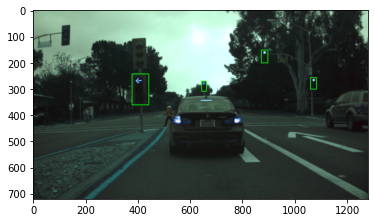

In [5]:
# Used to show test output
img = annotatePicture(train_key[23])
plt.imshow(img)

# Model Time

In [6]:
# Displaying encoding labels
labels = []
for i in range(len(train_key)):
    for boxes in train_key[i]['boxes']:
                if(boxes['label'] not in labels):
                    labels.append(boxes['label'])
labelDict = {}
for i in labels:
    labelDict[i] = labels.index(i)
# dict[label] = index

In [7]:
# Convert train.yaml to csv
def yaml_to_csv(train_key):
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    retList = []
    for i in range(len(train_key)):
        filePath = train_key[i]['path']
        # get img width and height
        width, height = cv2.imread(filePath).shape[:2]
        for boxes in train_key[i]['boxes']:
            classType = boxes['label']
            xmin = int(boxes['x_min'])
            ymin = int(boxes['y_min'])
            xmax = int(boxes['x_max'])
            ymax = int(boxes['y_max'])
            value = (filePath, width, height, classType, xmin, ymin, xmax, ymax)
            retList.append(value)
    
    return pd.DataFrame(retList, columns=column_name)

In [8]:
# Convert yaml to csv files for 
yaml_to_csv(train_key).to_csv('train.csv', index=None)